In [ ]:
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import decoupler as dc

# 忽略警告
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"


In [ ]:

# 从 Snakemake 获取参数
unique_prefix = snakemake.params.unique_prefix
input_file = snakemake.input[0]
output_file = snakemake.output[0]
figure_dir = snakemake.params.figure_dir
table_dir = snakemake.params.table_dir
log_file = snakemake.log[0]

# 设置日志输出
sys.stderr = open(log_file, "w")
sys.stdout = open(log_file, "w")

# 设置 Scanpy 参数
sc.settings.figdir = figure_dir


def setup_scanpy_params(n_jobs: int = -1, verbosity: int = 0) -> None:
    mpl.rcParams["pdf.fonttype"] = 42
    sc.settings.verbosity = verbosity
    sc.settings.n_jobs = n_jobs
    sc.settings.set_figure_params(
        dpi=80,
        dpi_save=600,
        facecolor="white",
        frameon=False,
    )


setup_scanpy_params()

# 基础参数
cell_type_col = snakemake.params.cell_type
groups_col = snakemake.params.condition_column
sample_group_column = snakemake.params.sample_group_column
condition_label = snakemake.params.ctrol_label
treatment_label = snakemake.params.treat_label

ANNO_COL = cell_type_col
GROUPs_COL = groups_col
CTROL = condition_label
STIM = treatment_label

# 加载数据
adata = sc.read(input_file)


In [ ]:

# 检查数据是否成功加载
if adata is None or adata.n_obs == 0:
    raise ValueError(f"Failed to load data from {input_file}")

# 检查必要的列是否存在
required_columns = [GROUPs_COL, ANNO_COL]
for col in required_columns:
    if col not in adata.obs.columns:
        raise ValueError(f"Required column {col} not found in adata.obs")

# 过滤数据
adata = adata[adata.obs[GROUPs_COL] == STIM].copy()
# 检查过滤后是否还有数据
if adata.n_obs == 0:
    raise ValueError(f"No cells remaining after filtering for {STIM}")

# 检索 CollecTRI 基因调控网络
net = dc.get_collectri(organism="human", split_complexes=False)


def run_ulm_inference(adata, net):
    """运行 ULM 推断并存储结果"""
    try:
        dc.run_ulm(
            mat=adata,
            net=net,
            source="source",
            target="target",
            weight="weight",
            verbose=True,
        )
        adata.obsm["collectri_ulm_estimate"] = adata.obsm["ulm_estimate"].copy()
        adata.obsm["collectri_ulm_pvals"] = adata.obsm["ulm_pvals"].copy()
    except Exception as e:
        raise RuntimeError(f"ULM inference failed: {str(e)}")


def get_tf_activities(adata, obsm_key="ulm_estimate"):
    """提取转录因子活性"""
    if obsm_key not in adata.obsm:
        raise KeyError(f"Required key {obsm_key} not found in adata.obsm")
    return dc.get_acts(adata, obsm_key=obsm_key)


def visualize_tf_activities(acts, genes=None, groupby=ANNO_COL):
    """可视化转录因子活性"""
    if genes is None:
        genes = ["PAX5"]

    # 检查指定的基因是否存在
    missing_genes = [g for g in genes if g not in acts.var_names]
    if missing_genes:
        warnings.warn(f"Genes not found in data: {missing_genes}")
        genes = [g for g in genes if g not in missing_genes]

    if not genes:
        raise ValueError("No valid genes to visualize")

    # 保存 UMAP 图
    axes = sc.pl.umap(
        acts, color=genes + [groupby], cmap="RdBu_r", vcenter=0, show=False
    )
    fig1 = axes[0].figure
    fig1.savefig(
        os.path.join(figure_dir, f"{unique_prefix}_umap_plot.pdf"),
        bbox_inches="tight",
        dpi=300,
    )
    plt.close(fig1)

    # 保存小提琴图
    fig2, ax = plt.subplots()
    ax = sc.pl.violin(acts, keys=genes, groupby=groupby, rotation=45, ax=ax, show=False)
    fig2.savefig(
        os.path.join(figure_dir, f"{unique_prefix}_violin_plot.pdf"),
        bbox_inches="tight",
        dpi=300,
    )
    plt.close(fig2)


def extract_top_markers_by_pvalue(
    acts, net, groupby=ANNO_COL, n_markers=3, max_pval=0.05
):
    """根据 p 值提取每个细胞类型的顶级转录因子"""
    if groupby not in acts.obs.columns:
        raise ValueError(f"Groupby column {groupby} not found in data")

    available_tfs = set(net["source"].unique())
    common_tfs = [tf for tf in acts.var_names if tf in available_tfs]
    if not common_tfs:
        raise ValueError(
            "No transcription factors found in both activity matrix and network"
        )

    print(
        f"Found {len(common_tfs)} transcription factors in both activity matrix and network"
    )

    # 执行差异分析
    df = dc.rank_sources_groups(
        acts[:, common_tfs],
        groupby=groupby,
        reference="rest",
        method="wilcoxon",
    )

    # 根据最大 p 值过滤
    df = df[df["pvals"] < max_pval].copy()

    if df.empty:
        warnings.warn("No significant transcription factors found")
        return {}

    # 按 p 值排序并选择顶级标记
    top_markers = (
        df.sort_values("pvals")
        .groupby("group")
        .head(n_markers)
        .groupby("group")["names"]
        .apply(list)
        .to_dict()
    )

    if not top_markers:
        warnings.warn("No markers found for any group")
    else:
        print("Found markers per group:", top_markers)

    return top_markers


def plot_tf_network(net, n_sources=None, n_targets=15, save=None):
    """绘制网络图"""
    if n_sources is None:
        n_sources = ["PAX5", "EBF1", "RFXAP"]

    missing_tfs = [tf for tf in n_sources if tf not in net["source"].unique()]
    if missing_tfs:
        warnings.warn(f"Transcription factors not found in network: {missing_tfs}")
        n_sources = [tf for tf in n_sources if tf not in missing_tfs]

    if not n_sources:
        raise ValueError("No valid transcription factors to plot")

    dc.plot_network(
        net=net,
        n_sources=n_sources,
        n_targets=n_targets,
        node_size=50,
        s_cmap="white",
        t_cmap="white",
        c_pos_w="darkgreen",
        c_neg_w="darkred",
        figsize=(8, 8),
        save=save,
    )


try:
    run_ulm_inference(adata, net)
    acts = get_tf_activities(adata)
    visualize_tf_activities(acts)
    source_markers = extract_top_markers_by_pvalue(acts, net, ANNO_COL)
    plot_tf_network(
        net,
        source_markers,
        save=os.path.join(figure_dir, f"{unique_prefix}_tf_network.pdf"),
    )

    # 保存 ULM 估计值和 p 值到 CSV
    estimate_df =adata.obsm["collectri_ulm_estimate"]
    
    estimate_df.to_csv(os.path.join(table_dir, f"{unique_prefix}_ulm_estimates.csv"))

    pvals_df = adata.obsm["collectri_ulm_pvals"]
    pvals_df.to_csv(os.path.join(table_dir, f"{unique_prefix}_ulm_pvals.csv"))

    with open(output_file, mode="wt") as f:
        f.write("Analysis completed successfully.")
except Exception as e:
    error_message = f"Analysis failed: {str(e)}"
    with open(output_file, mode="wt") as f:
        f.write(error_message)
    raise RuntimeError(error_message)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 608 sources.


  0%|          | 0/1 [00:00<?, ?it/s]

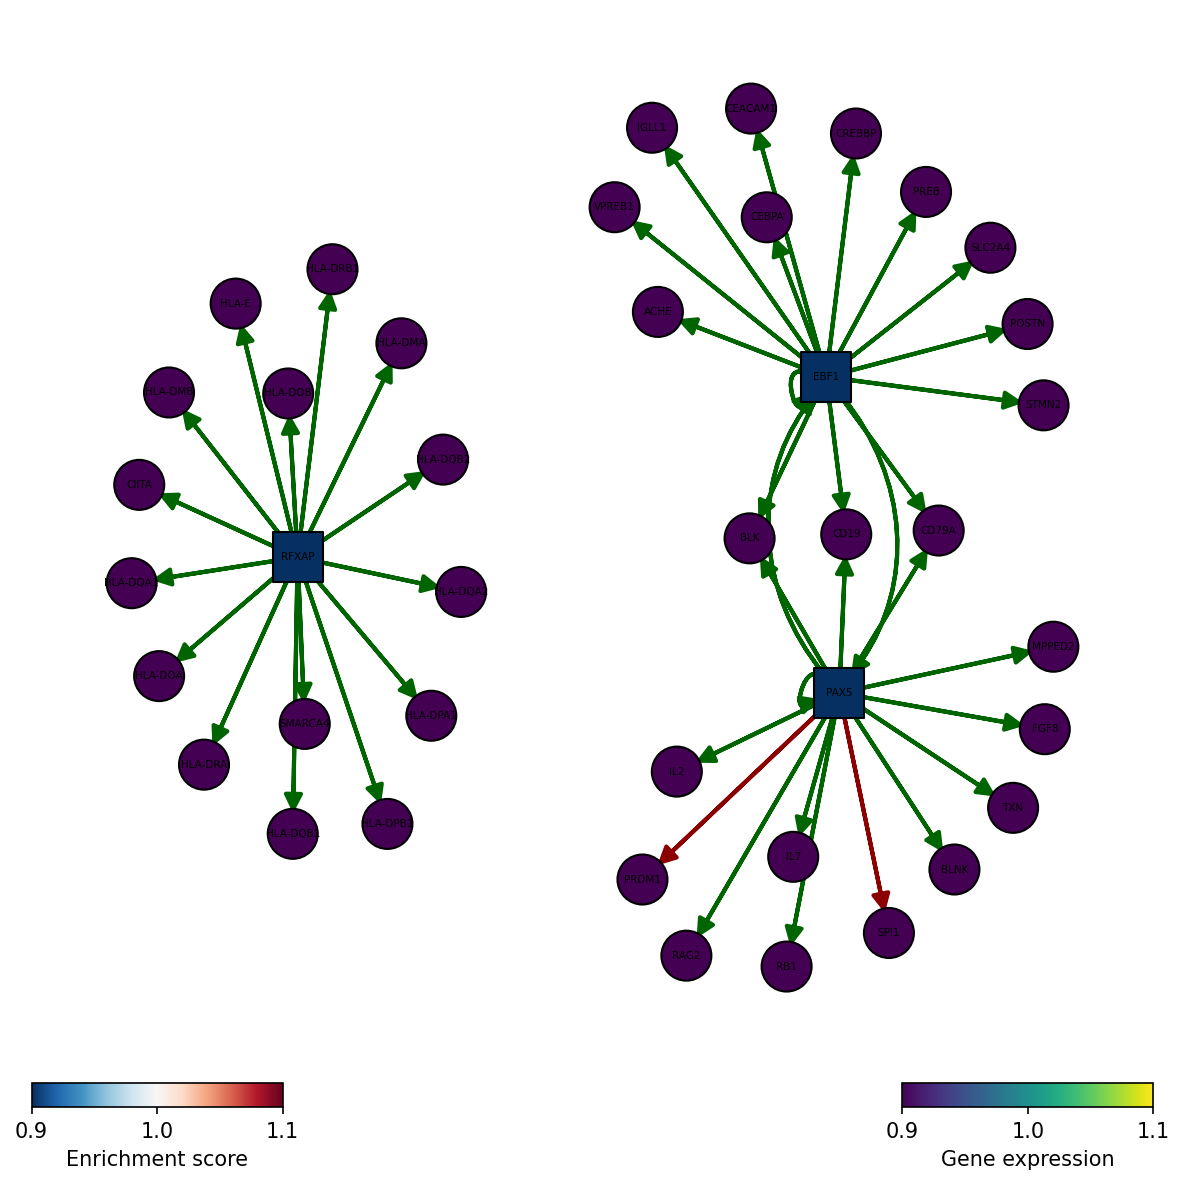

In [ ]:
import scanpy as sc
import decoupler as dc

# 参数和变量定义
organism = 'human'
split_complexes = False
obsm_key_estimate = 'ulm_estimate'
obsm_key_pvals = 'ulm_pvals'
n_markers = 3
n_sources = ['PAX5', 'EBF1', 'RFXAP']
n_targets = 15
node_size = 50
figsize_network = (8, 8)
color_map = 'RdBu_r'
vcenter = 0

# 加载数据
adata = sc.datasets.pbmc3k_processed()

# 检索 CollecTRI 基因调控网络
net = dc.get_collectri(organism=organism, split_complexes=split_complexes)

# 使用单变量线性模型 (ULM) 进行活动推断
def run_ulm_inference(adata, net):
    dc.run_ulm(
        mat=adata,
        net=net,
        source='source',
        target='target',
        weight='weight',
        verbose=True
    )
    adata.obsm['collectri_ulm_estimate'] = adata.obsm[obsm_key_estimate].copy()
    adata.obsm['collectri_ulm_pvals'] = adata.obsm[obsm_key_pvals].copy()

# 提取活动分数
def get_tf_activities(adata, obsm_key):
    acts = dc.get_acts(adata, obsm_key=obsm_key)
    return acts

# 可视化活动
def visualize_tf_activities(acts, color_map, vcenter):
    import matplotlib.pyplot as plt
# 对于 umap 图
    axes = sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap=color_map, vcenter=vcenter, show=False)
    fig1 = axes[0].figure  # 获取图形对象
    fig1.savefig('umap_plot.pdf', bbox_inches='tight', dpi=300)
    plt.close(fig1)  # 记得关闭图形释放内存

    # 对于小提琴图
    fig2, ax = plt.subplots()
    ax = sc.pl.violin(acts, keys=['PAX5'], groupby='louvain', rotation=90, ax=ax, show=False)
    fig2.savefig('violin_plot.pdf', bbox_inches='tight', dpi=300)
    plt.close(fig2)

# 确定每个细胞类型的顶级 TF
def rank_and_extract_top_markers(acts, groupby, n_markers):
    df = dc.rank_sources_groups(acts, groupby=groupby, reference='rest', method='t-test_overestim_var')
    source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
    return source_markers

# 绘制网络图
def plot_tf_network(net, n_sources, n_targets, node_size, figsize):
    dc.plot_network(
        net=net,
        n_sources=n_sources,
        n_targets=n_targets,
        node_size=node_size,
        s_cmap='white',
        t_cmap='white',
        c_pos_w='darkgreen',
        c_neg_w='darkred',
        figsize=figsize
    )

# 执行推断和可视化
run_ulm_inference(adata, net)
acts = get_tf_activities(adata, obsm_key_estimate)
visualize_tf_activities(acts, color_map, vcenter)
source_markers = rank_and_extract_top_markers(acts, groupby='louvain', n_markers=n_markers)
plot_tf_network(net, n_sources, n_targets, node_size, figsize_network)
